# Prepare Environment

In [15]:
import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import dask_ml.model_selection as dcv
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold, GridSearchCV

import gc
import pickle
import time
from contextlib import contextmanager

In [2]:
#Clear memory when restarting kernel
gc.collect()

0

In [6]:
#set global seed var
seed = 40

### Define Timer Function

In [5]:
# Helping time blocks of code
@contextmanager
def timed(txt):
    t0 = time.time()
    yield
    t1 = time.time()
    print("%32s time:  %8.5f" % (txt, t1 - t0))

# Load Dataset

In [4]:
#Read smote data back to nb ad cuda df
X_train = pd.read_parquet(r"../../capstone_data/archive/SMOTE_train_test_split/X_train_smote.parquet")
y_train = pd.read_parquet(r"../../capstone_data/archive/SMOTE_train_test_split/y_train_smote.parquet")['label']
X_test = pd.read_parquet(r"../../capstone_data/archive/SMOTE_train_test_split/X_test_smote.parquet")
y_test = pd.read_parquet(r"../../capstone_data/archive/SMOTE_train_test_split/y_test_smote.parquet")['label']

print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


# Perform Gridsearch

In [44]:
%%time
# CPU times: user 4h 29min 50s, sys: 15min 11s, total: 4h 45min 1s
# Wall time: 1d 22h 42min 5s

model_ab = AdaBoostClassifier(random_state=seed)

params_ab = {
    'n_estimators': [10, 50, 100, 200, 500, 1000],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]
}

# define the evaluation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

grid_search = GridSearchCV(estimator=model_ab, param_grid=params_ab, n_jobs=-1, cv=cv, scoring='f1_macro', verbose=3)

# execute the grid search
grid_result = grid_search.fit(X_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/lix/miniconda3/envs/rapids/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/lix/miniconda3/envs/rapids/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/lix/miniconda3/envs/rapids/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/lix/miniconda3/envs/rapids/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

[CV 2/5] END learning_rate=0.0001, n_estimators=10;, score=0.787 total time= 2.9min
[CV 4/5] END learning_rate=0.0001, n_estimators=50;, score=0.786 total time=12.7min
[CV 4/5] END learning_rate=0.0001, n_estimators=100;, score=0.786 total time=24.8min
[CV 5/5] END learning_rate=0.0001, n_estimators=200;, score=0.913 total time=47.2min
[CV 5/5] END learning_rate=0.0001, n_estimators=500;, score=0.913 total time=118.6min
[CV 1/5] END learning_rate=0.001, n_estimators=10;, score=0.786 total time= 2.4min
[CV 2/5] END learning_rate=0.001, n_estimators=10;, score=0.787 total time= 2.4min
[CV 3/5] END learning_rate=0.001, n_estimators=10;, score=0.786 total time= 2.4min
[CV 4/5] END learning_rate=0.001, n_estimators=10;, score=0.786 total time= 2.4min
[CV 5/5] END learning_rate=0.001, n_estimators=10;, score=0.787 total time= 2.4min
[CV 1/5] END learning_rate=0.001, n_estimators=50;, score=0.912 total time=11.8min
[CV 2/5] END learning_rate=0.001, n_estimators=50;, score=0.913 total time=11.

In [52]:
#Tabulate gridsearch results
# adaboost_gridsearch_res_df = pd.concat([pd.DataFrame(grid_result.cv_results_["params"]),pd.DataFrame(grid_result.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
# adaboost_gridsearch_res_df.to_csv('trained_models/adaboost_gridsearch_res.csv', index=False)
# adaboost_gridsearch_res_df

,learning_rate,n_estimators,Accuracy
0,0.0001,10,0.786364
1,0.0001,50,0.786364
2,0.0001,100,0.786364
3,0.0001,200,0.912357
4,0.0001,500,0.912357
5,0.0001,1000,0.912357
6,0.0010,10,0.786364
7,0.0010,50,0.912357
8,0.0010,100,0.912357
9,0.0010,200,0.912357


# Train with Official Parameters

In [59]:
grid_result.best_params_

{'learning_rate': 1.0, 'n_estimators': 1000}

In [53]:
%%time
#Executes in 3hrs, 19mins, and 51secs
best_params_ab = AdaBoostClassifier(n_estimators=1000, learning_rate=1.0, random_state=seed)

# Fit the model to the training data
ada_model = best_params_ab.fit(X_train, y_train)

CPU times: user 3h 20min 18s, sys: 3min 32s, total: 3h 23min 51s
Wall time: 3h 19min 51s


In [56]:
%%time
#Executes in 3min and 8 secs
# Make predictions on the testing data
y_pred = ada_model.predict(X_test)

CPU times: user 3min 10s, sys: 609 ms, total: 3min 11s
Wall time: 3min 8s


# Evaluate Model

In [11]:
#load model if already trained
filename = '../trained_models/AB_model_HPO_9998accuracy.pkl'

with open(filename, 'rb') as file:
    ada_model = pickle.load(file)

y_pred = ada_model.predict(X_test)

In [13]:
#Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9998054704710325
Precision: 0.9998054715681319
Recall: 0.9998054743043971
F1 Score: 0.9998054704708847


### Confusion Matrix

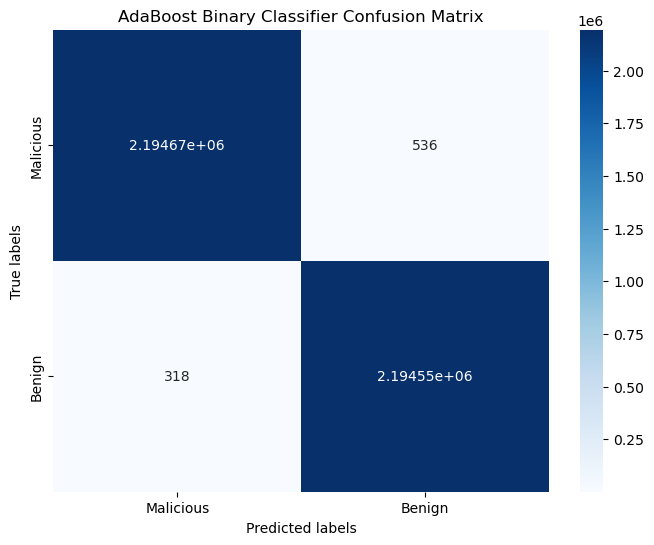

In [22]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Malicious', 'Benign'], yticklabels=['Malicious', 'Benign'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('AdaBoost Binary Classifier Confusion Matrix')
plt.savefig('../../Graphs/Conf_Mat/AB_HPO_CM_maxdepth13_maxfeatures05_nestimators200.png')
plt.show()

### ROC Curve

In [20]:
y_probs = ada_model.predict_proba(X_test)
y_probs

array([[0.49571483, 0.50428517],
       [0.50374897, 0.49625103],
       [0.49621878, 0.50378122],
       ...,
       [0.50437206, 0.49562794],
       [0.50331232, 0.49668768],
       [0.50442496, 0.49557504]])

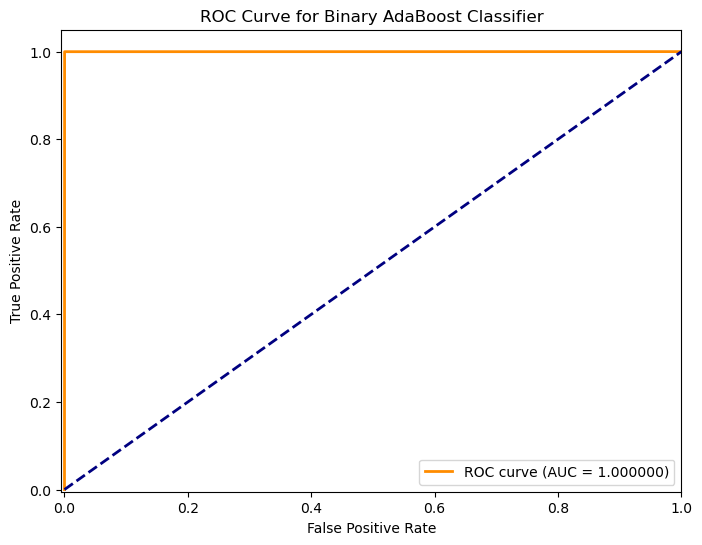

In [21]:
#Calculate prediction performance metrics
fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.6f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.005, 1.0])
plt.ylim([-0.005, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary AdaBoost Classifier')
plt.legend(loc="lower right")
plt.savefig('../../Graphs/ROC_CUR/AB_HPO_ROC_learning_rate1_nestimators1000.png')
plt.show()

# Saving the model

In [79]:
# import pickle

# # Save the trained model using pickle
# model_filename = 'trained_models/AB_model_HPO_9998accuracy.pkl'
# with open(model_filename, 'wb') as file:
#     pickle.dump(ada_model, file)